# Initial Segmentation

This notebook will explore segmentation options for the 2 processed image data-sets


## Author: Alexander Goudemond, Student Number: 219030365

# Imports

In [9]:
from os import getcwd, walk, mkdir
from os.path import join

import cv2
from PIL.Image import fromarray

import numpy as np

import matplotlib.pyplot as plt

# Loading Test Images

This section of the notebook focusses on loading 10 images to explore segmentation

In [2]:

def getFirstTenPics(desired_directory, directory_array):
    # Now, generate the array of images
    test_images = []
    current_directory = getcwd()

    path = walk(current_directory+ "\\" + desired_directory)

    i = -1
    temp = -1
    for root, dirs, files in path:
        # print(dirs)
        for item in files:
            # only execute for first picture in directory
            if ("t0000.tif" in item) or ("t000.tif" in item):
                i += 1

                # skips folder "02" in data-sets
                if (i % 2 == 1):
                    break
                    
                # print(i)
                temp = i // 2

                # skip Challenge data-sets
                if ("(1)" in directory_array[temp]):
                    break

                location = ( current_directory + "\\" + desired_directory + "\\" + directory_array[temp] + 
                            "\\" + directory_array[temp] + "\\01\\" + item)
                # print(location)

                img = cv2.imread(location, cv2.IMREAD_GRAYSCALE)

                test_images.append(img) # place into array

                break

            else:
                break
            
    return resizeImageArray(test_images)
###

def resizeImageArray(image_array):
    new_array = []
    x = -1; y = -1

    for i in range(len(image_array)):
        img = image_array[i]

        if (i == 0):
            (x, y) = img.shape
            x = x // 2
            y = y // 2
        
        img_reshaped = cv2.resize(img, (x, y))
        new_array.append(img_reshaped)
    
    return new_array
###

In [3]:
'''
We only need to show every _OTHER_ folder, as each data-set has a 
 training and challenge set. So out of 20 files, we need to show 10

First things first, let us create an array of the directory locations
'''

data_sets = "..\\..\\Comp700_DataSets"
current_directory = getcwd()

path = walk(current_directory + "\\" + data_sets)

directory_array = [] # contains the main folders

i = 1
for root, dirs, files in path:
    if (i == 2):
        directory_array = dirs
        break
    
    i += 1

print("Directory Array")
print(directory_array)


Directory Array
['BF-C2DL-HSC', 'BF-C2DL-HSC (1)', 'BF-C2DL-MuSC', 'BF-C2DL-MuSC (1)', 'DIC-C2DH-HeLa', 'DIC-C2DH-HeLa (1)', 'Fluo-C2DL-Huh7', 'Fluo-C2DL-Huh7 (1)', 'Fluo-C2DL-MSC', 'Fluo-C2DL-MSC (1)', 'Fluo-N2DH-GOWT1', 'Fluo-N2DH-GOWT1 (1)', 'Fluo-N2DH-SIM+', 'Fluo-N2DH-SIM+ (1)', 'Fluo-N2DL-HeLa', 'Fluo-N2DL-HeLa (1)', 'PhC-C2DH-U373', 'PhC-C2DH-U373 (1)', 'PhC-C2DL-PSC', 'PhC-C2DL-PSC (1)']


In [4]:
location1 = "..\\..\\Comp700_Processed_DataSets_1"
location1_pics = getFirstTenPics(location1, directory_array)

print( len(location1_pics) )

10


In [6]:
location2 = "..\\..\\Comp700_Processed_DataSets_2"
location2_pics = getFirstTenPics(location2, directory_array)

print( len(location2_pics) )

10


In [10]:
# from PIL.Image import fromarray

def stitchTogetherPics(array_of_images):
    # top level
    myList = (array_of_images[0], array_of_images[1], array_of_images[2], array_of_images[3], array_of_images[4])
    numpy_horizontal_top = np.hstack(myList)

    # bottom level
    myList = (array_of_images[5], array_of_images[6], array_of_images[7], array_of_images[8], array_of_images[9])
    numpy_horizontal_bottom = np.hstack(myList)

    # stick 2 ontop of one another
    myList = (numpy_horizontal_top, numpy_horizontal_bottom)
    numpy_final_pic_concat = np.concatenate(myList, axis=0)

    return numpy_final_pic_concat
###

# save and show in cell
def saveAndShow(desired_directory, image_array, picName):
    fileName = desired_directory + "\\" + picName

    # Save pic to file, using Pillow!
    new_img = fromarray(stitchTogetherPics(image_array))
    new_img.save(fileName) # save using Pillow

    width = 30
    height = 10
    fig = plt.figure()
    fig.set_figwidth(width); fig.set_figheight(height)

    new_img = plt.imread(fileName)
    plt.title(picName)
    plt.axis('off')
    plt.imshow(new_img, cmap='gray')
###

def tryMakeDirectory(current_directory, destination_directory):
    try:
        # join comes from os.path
        mkdir( join(current_directory, destination_directory) )
    except FileExistsError:
        # print("Folder already exists!")
        pass
    except:
        print("Unknown Error Encountered...")
###

In [11]:
destination_directory = "007_Initial_Segmentation"
tryMakeDirectory(current_directory, destination_directory)

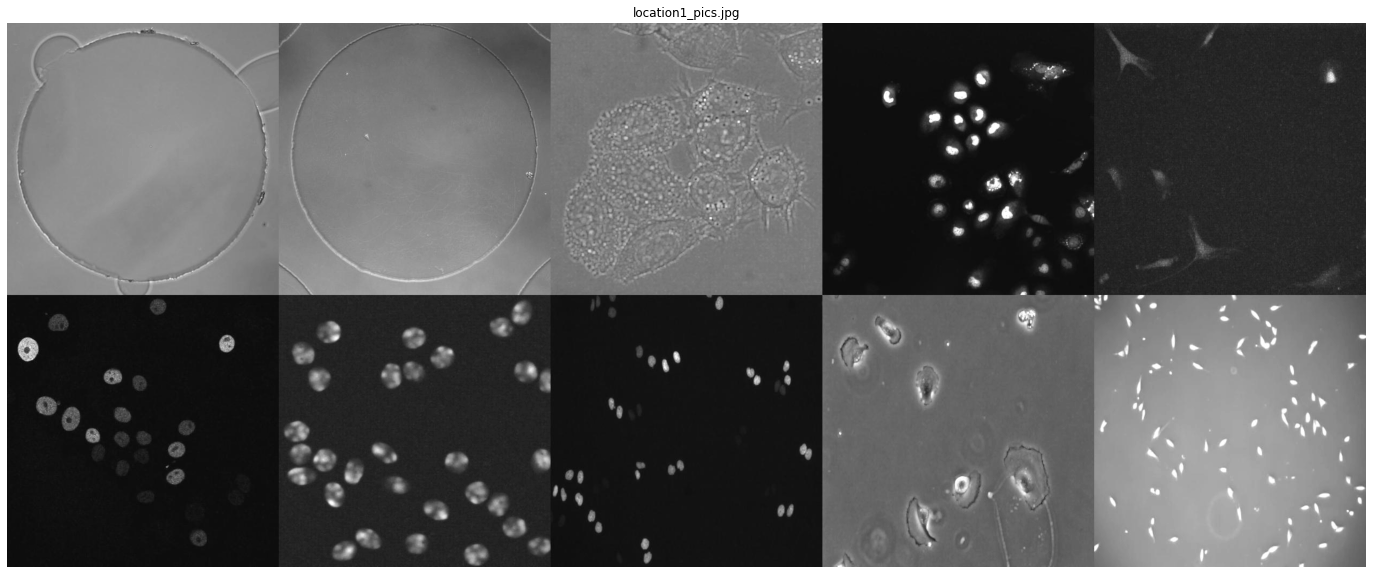

In [12]:
saveAndShow(destination_directory, location1_pics, "location1_pics.jpg")

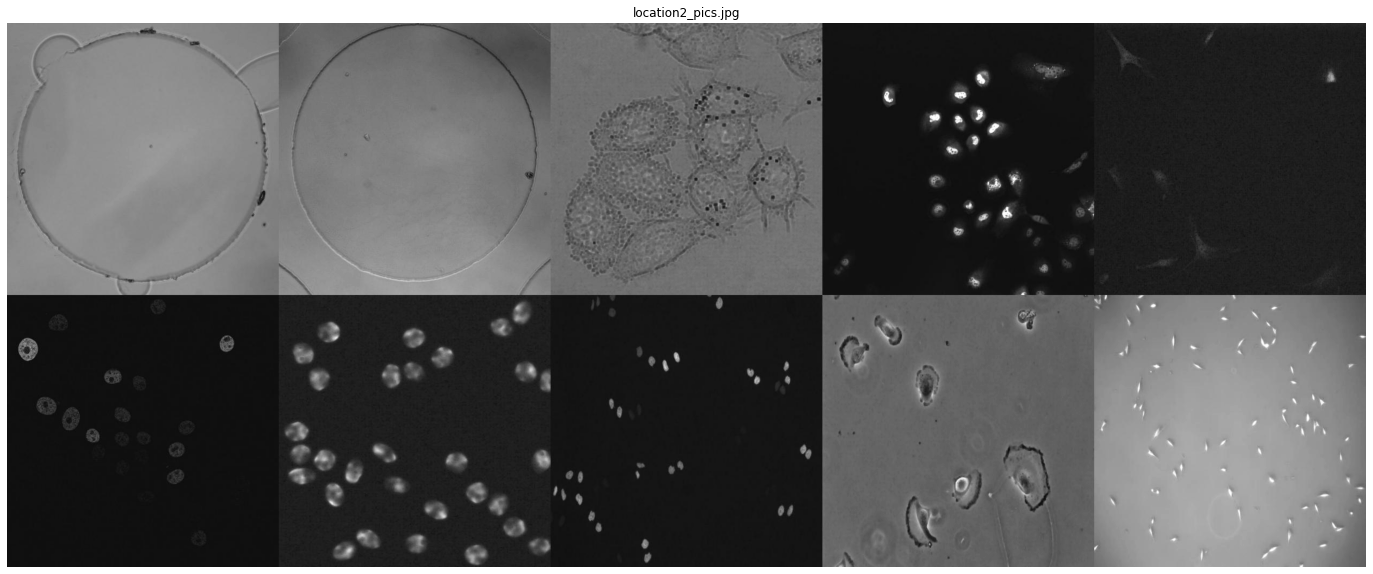

In [13]:
saveAndShow(destination_directory, location2_pics, "location2_pics.jpg")

Great! We now have the initial functions we need to save the work to our folder, as well as our 2 objects of test images

# Segmentation Options

This section of the notebook looks at segmentation options on our 2 test images

There are several segmentation options that can be used. Let us refer to our honours proposal for any non-deep learning techniques for segmentation. Let us look at the data gather in the proposal here:

![CTC Segmentation techniques](Proposal_Segmentation_Methods.PNG "CTC Segmentation techniques")

The CTC challenge focussed on algorithms for specific data-sets, so each team could have prepared seperate algorithms for each one present. I have already attempted the Pre Processing. Also, the thresholding attempted was almost successful, but not for all data-sets!

Instead, let us initially consider the following Methodologies: 

- Energy Minimization

- Region Growing

We can further attempt to segment the image, using:

- Watershed Segmentation

- Edge Detection

- K-Means Clustering

- Thresholding and Segmentation Combinations

Watershed method:

In [14]:
def watershedSegmentation(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((3,3),np.uint8)
    # print(kernel)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    unsure_pic = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, unsure_pic)

    # Marker labelling
    ret, markers = cv2.connectedComponents(unsure_pic)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    # NOW - Watershed method
    watershedImage = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    finalMarkers = cv2.watershed(watershedImage, markers) #! needs colour image

    watershedImage[finalMarkers == -1] = [255, 0, 0]
    watershedImage = cv2.cvtColor(watershedImage, cv2.COLOR_BGR2GRAY) #! convert back to grayscale

    return watershedImage

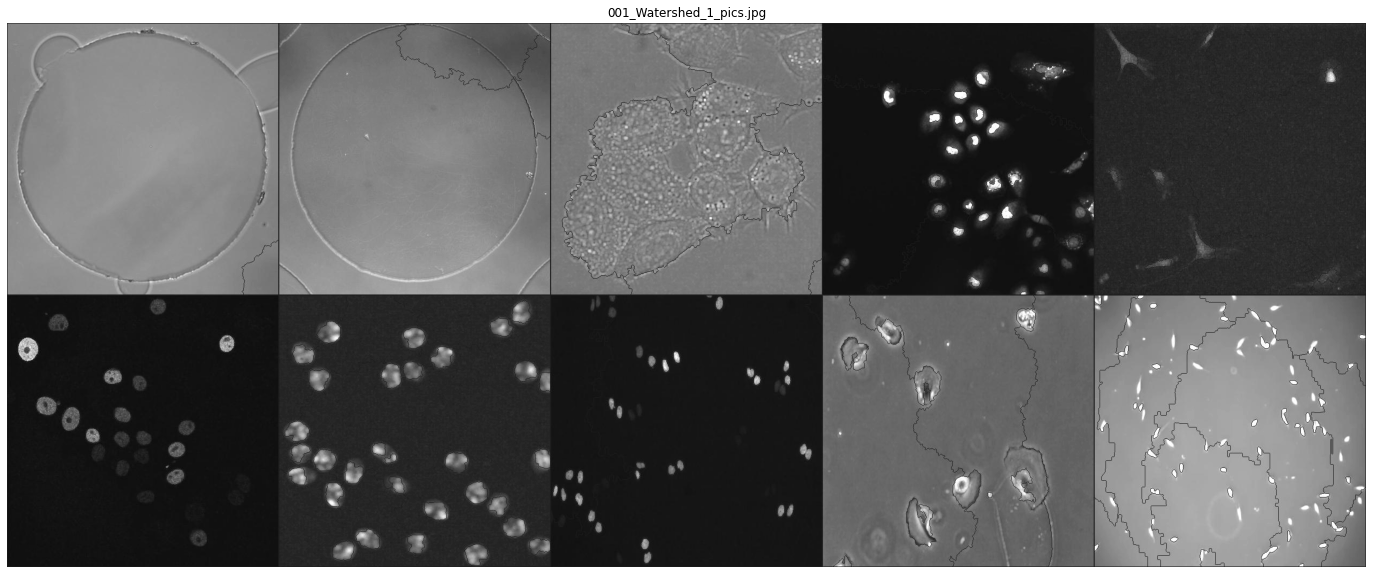

In [15]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedSegmentation(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "001_Watershed_1_pics.jpg")

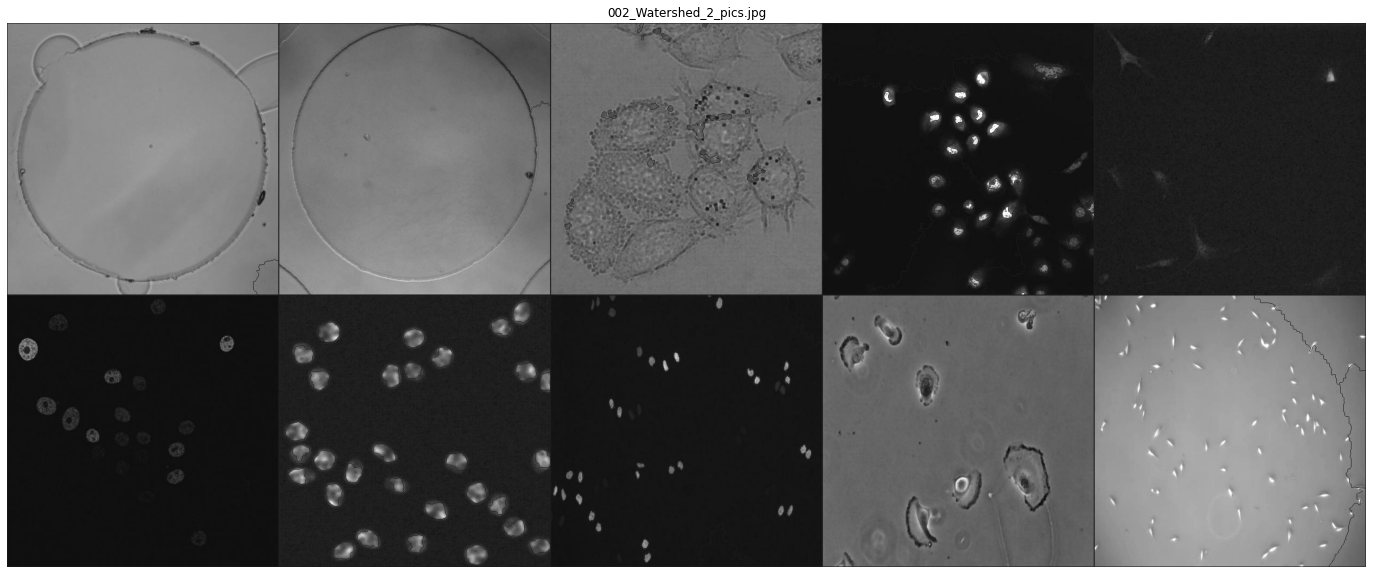

In [16]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedSegmentation(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "002_Watershed_2_pics.jpg")

Curiously, Watershed method performed better for locations1 than locations2. Perhaps the thresholding is the problem? Let us check:

In [20]:
def watershedThresholding(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    return thresh

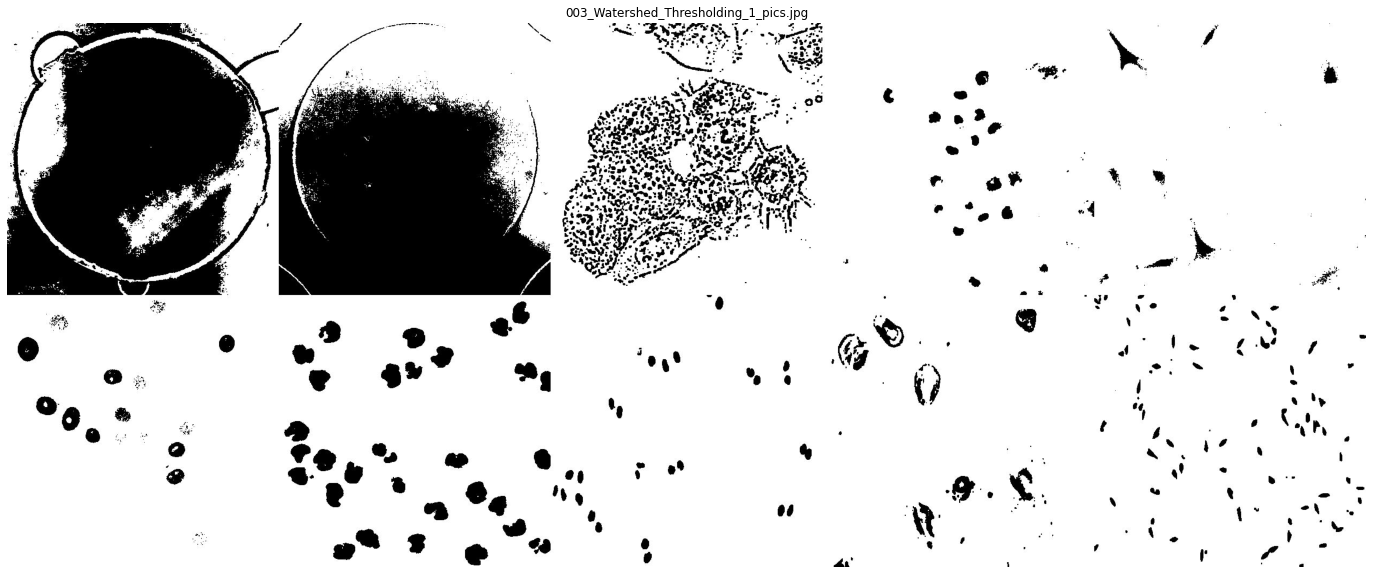

In [18]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholding(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "003_Watershed_Thresholding_1_pics.jpg")

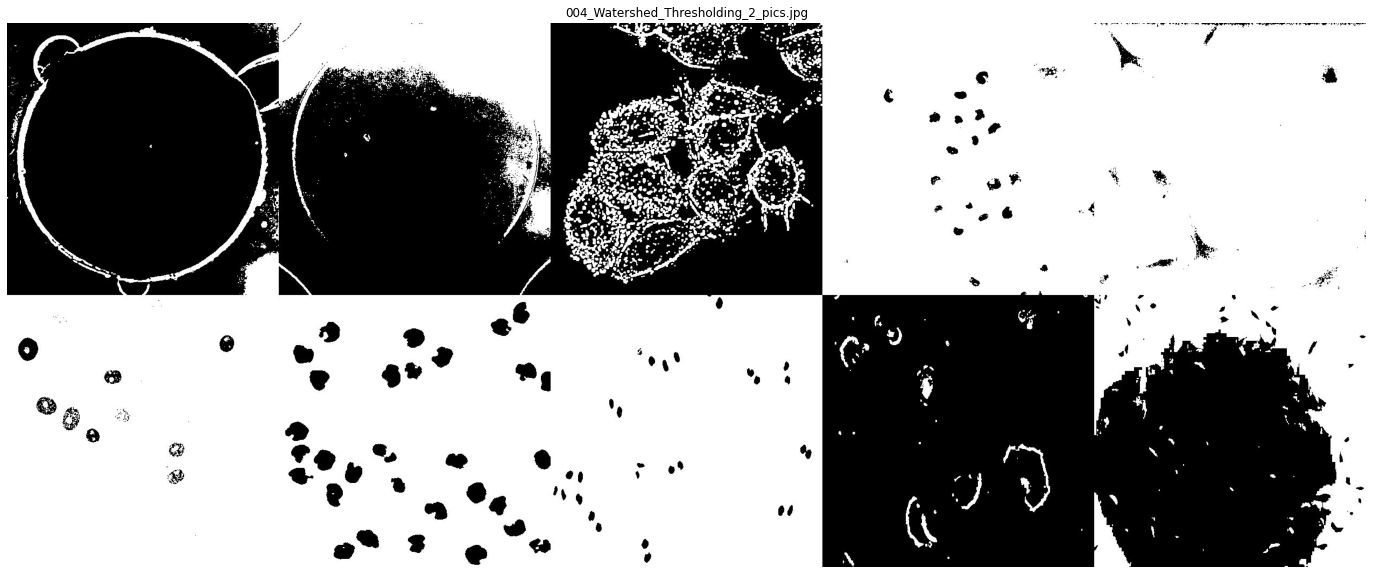

In [19]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholding(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "004_Watershed_Thresholding_2_pics.jpg")

Hay! Those thresholded pictures are great! They have problems for the first 2 and last data-sets (Namely because of the lighting) but the 3rd data-set is preserved well!

What if we try that again, but using the adaptive thresholding instead of Otsu?

In [21]:
def watershedThresholdingAdapted(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.ADAPTIVE_THRESH_MEAN_C)

    return thresh

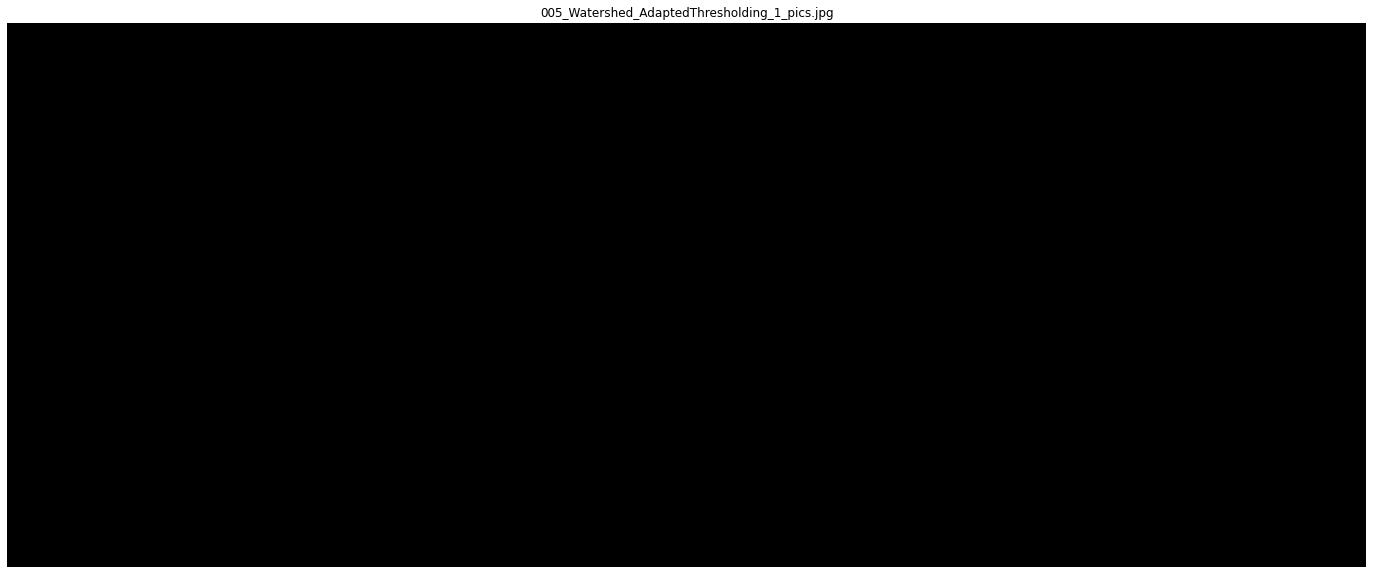

In [22]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "005_Watershed_AdaptedThresholding_1_pics.jpg")

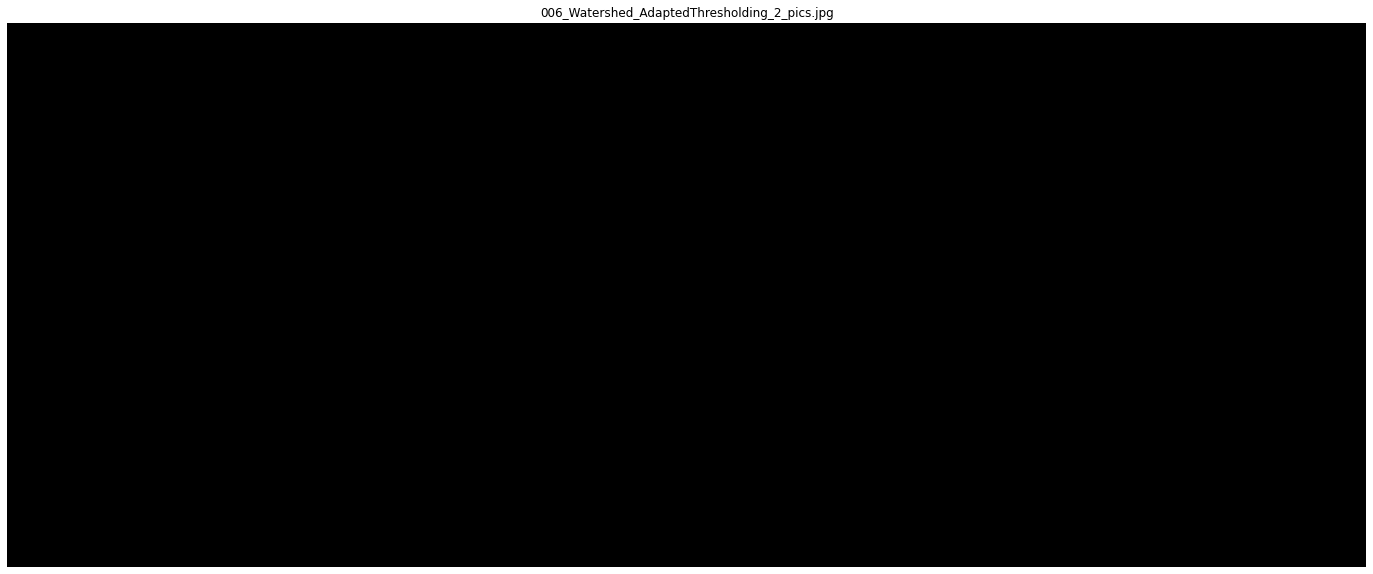

In [23]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholdingAdapted(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "006_Watershed_AdaptedThresholding_2_pics.jpg")

Nope! just 1 variable?

In [24]:
def watershedThresholdingAdapted2(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.ADAPTIVE_THRESH_MEAN_C)

    return thresh

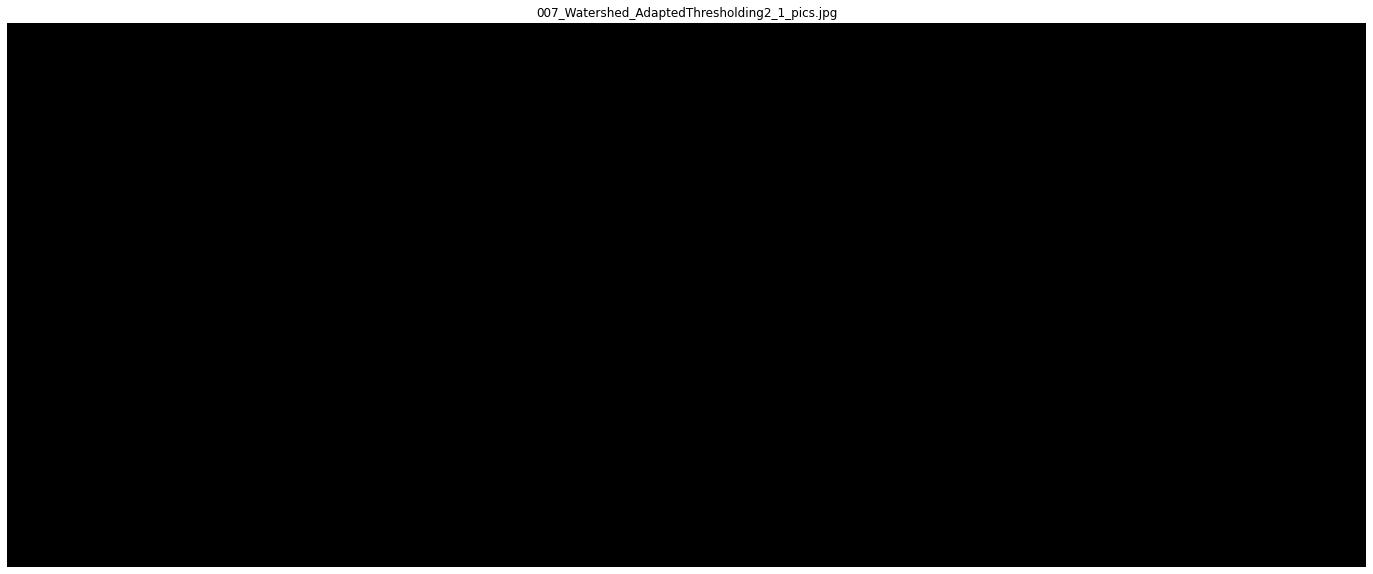

In [25]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted2(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "007_Watershed_AdaptedThresholding2_1_pics.jpg")

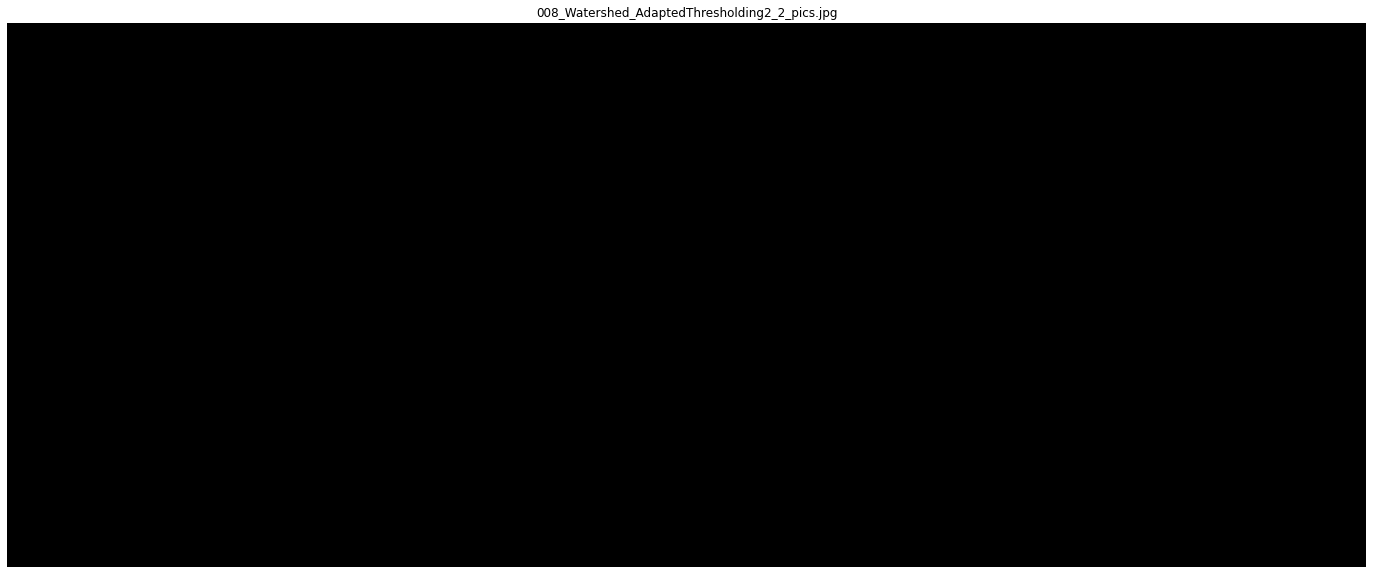

In [26]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholdingAdapted2(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "008_Watershed_AdaptedThresholding2_2_pics.jpg")

No, that option is terrible... What about other combinations?

In [33]:
def watershedThresholdingAdapted3(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_MASK)

    return thresh

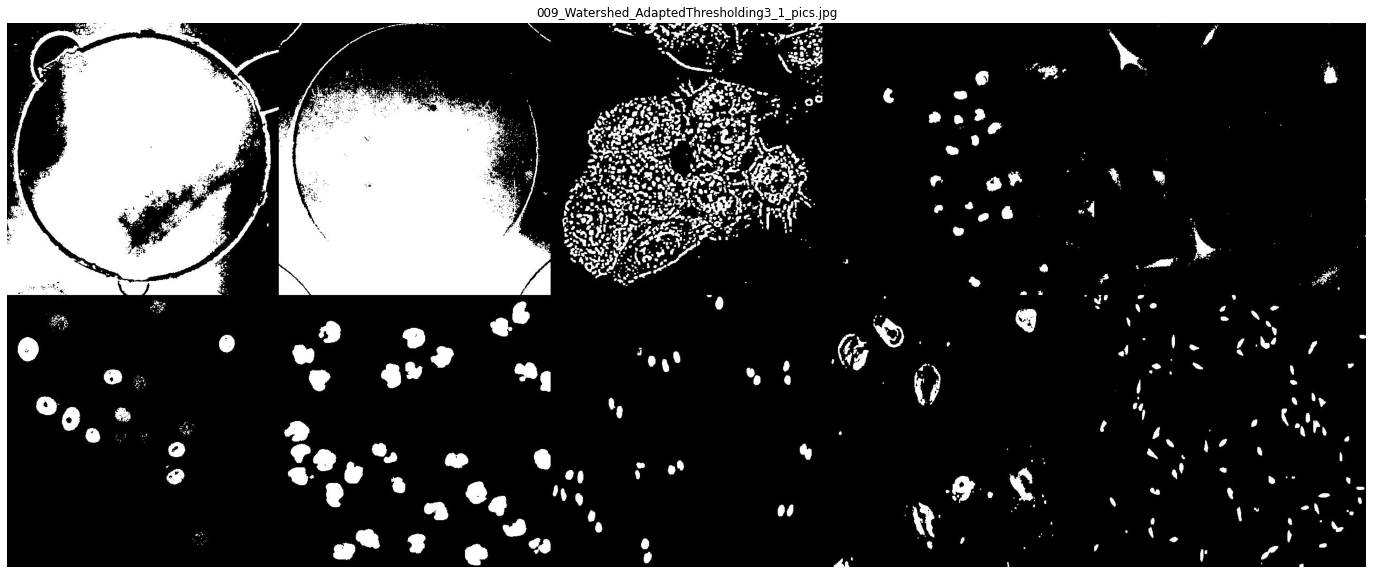

In [34]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted3(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "009_Watershed_AdaptedThresholding3_1_pics.jpg")

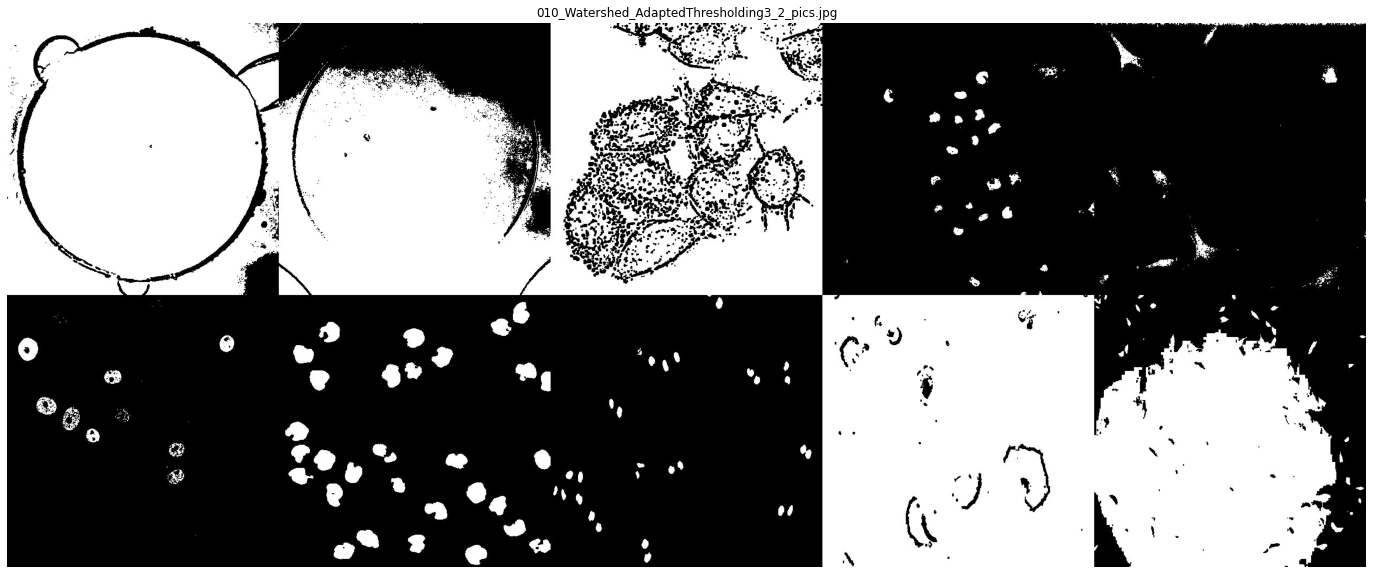

In [35]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholdingAdapted3(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "010_Watershed_AdaptedThresholding3_2_pics.jpg")

Let us keep going:

In [42]:
def watershedThresholdingAdapted4(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_TRUNC)

    return thresh

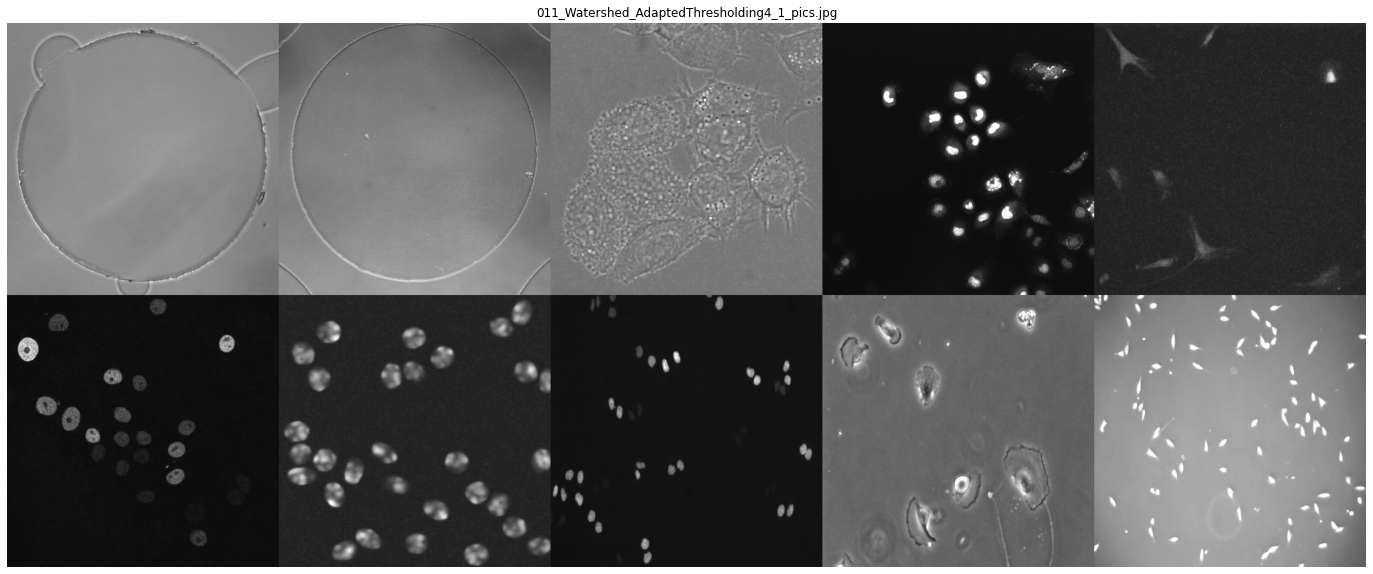

In [43]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted4(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "011_Watershed_AdaptedThresholding4_1_pics.jpg")

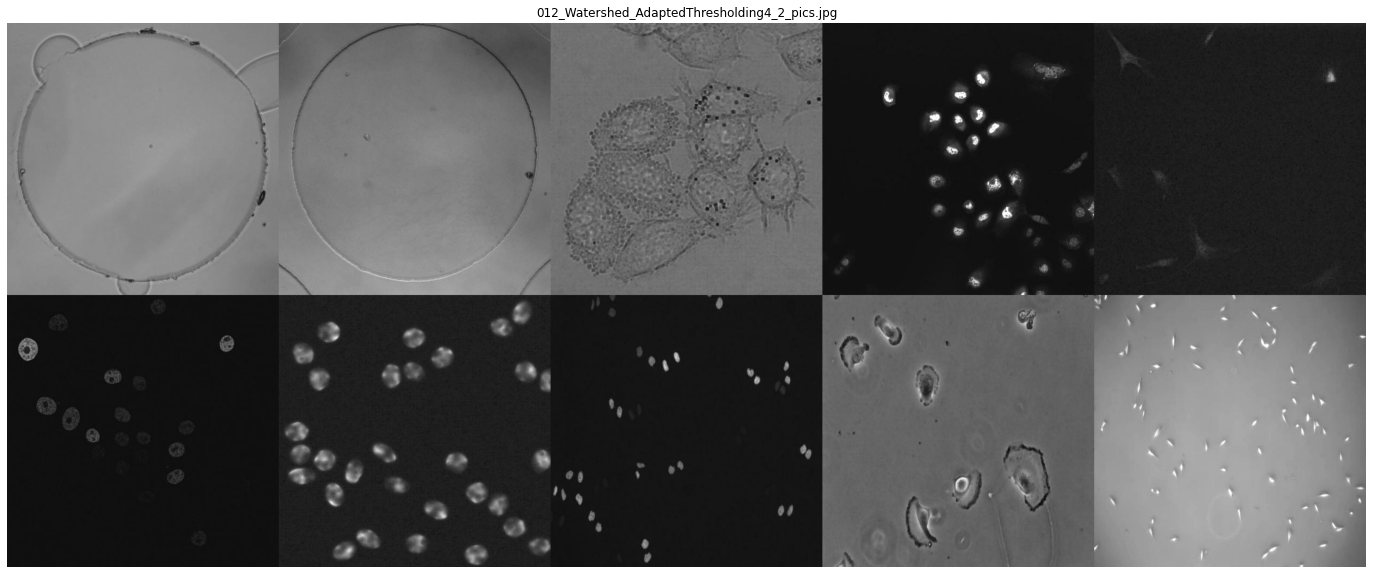

In [44]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholdingAdapted4(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "012_Watershed_AdaptedThresholding4_2_pics.jpg")

That did nothing! Let us try other combinations:

In [48]:
def watershedThresholdingAdapted5(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE)

    return thresh

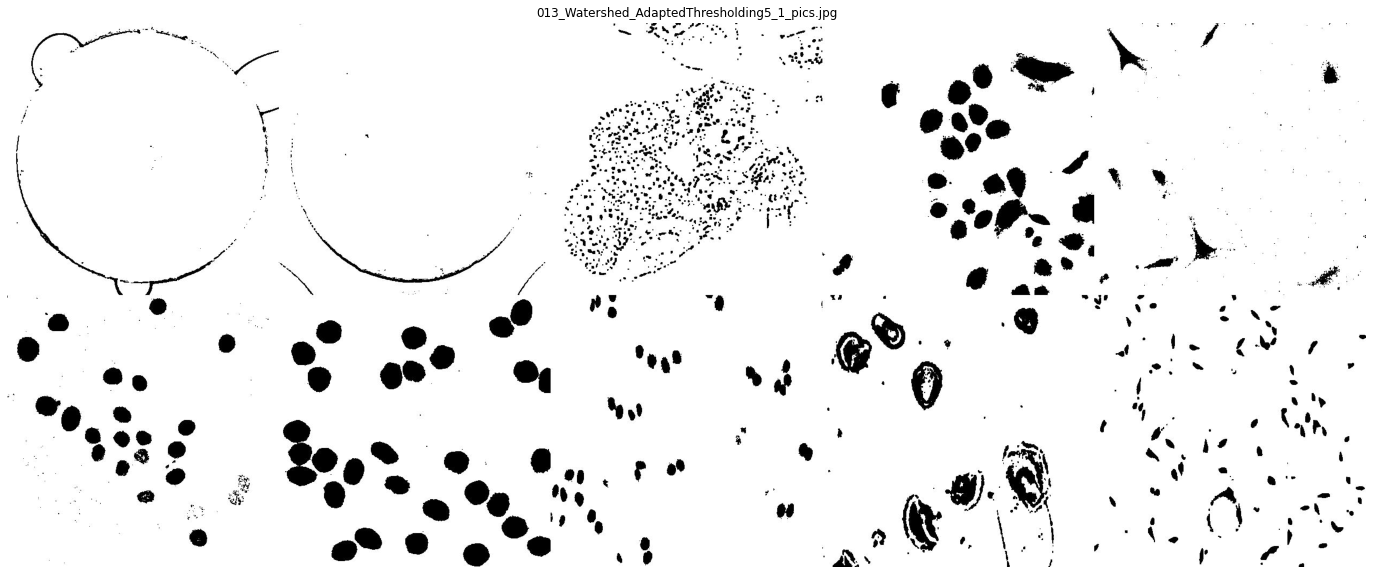

In [49]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted5(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "013_Watershed_AdaptedThresholding5_1_pics.jpg")

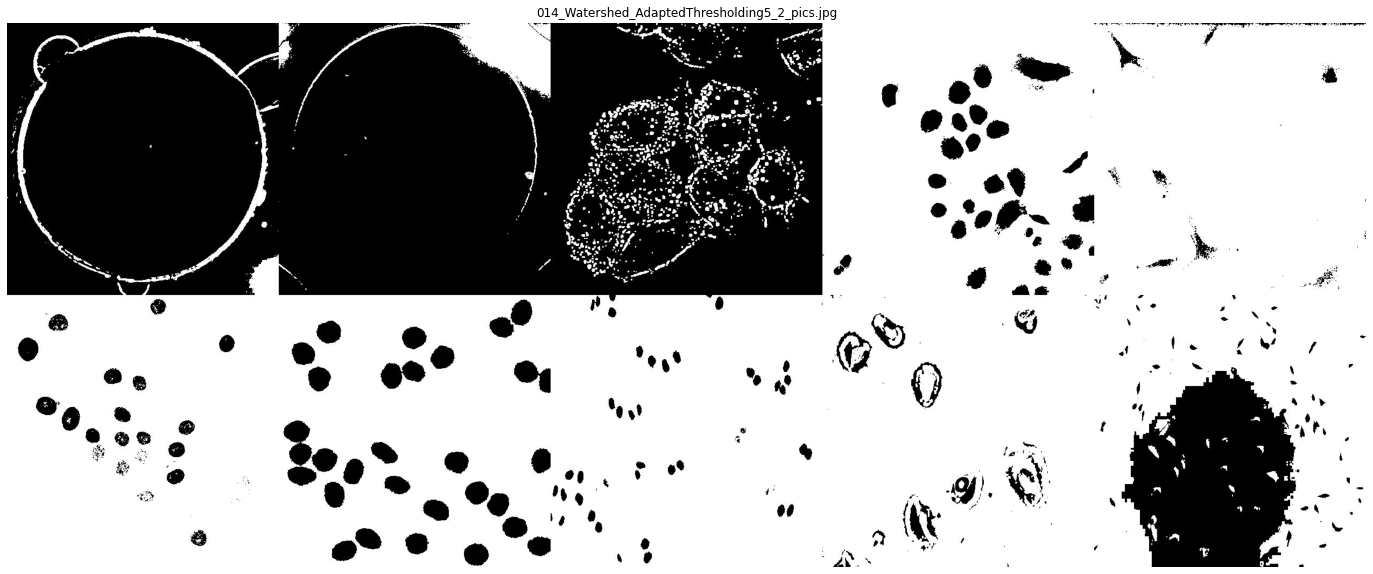

In [50]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholdingAdapted5(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "014_Watershed_AdaptedThresholding5_2_pics.jpg")

That top 1 is amazing! What does the triangle do by itself?

In [51]:
def watershedThresholdingAdapted6(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_TRIANGLE)

    return thresh

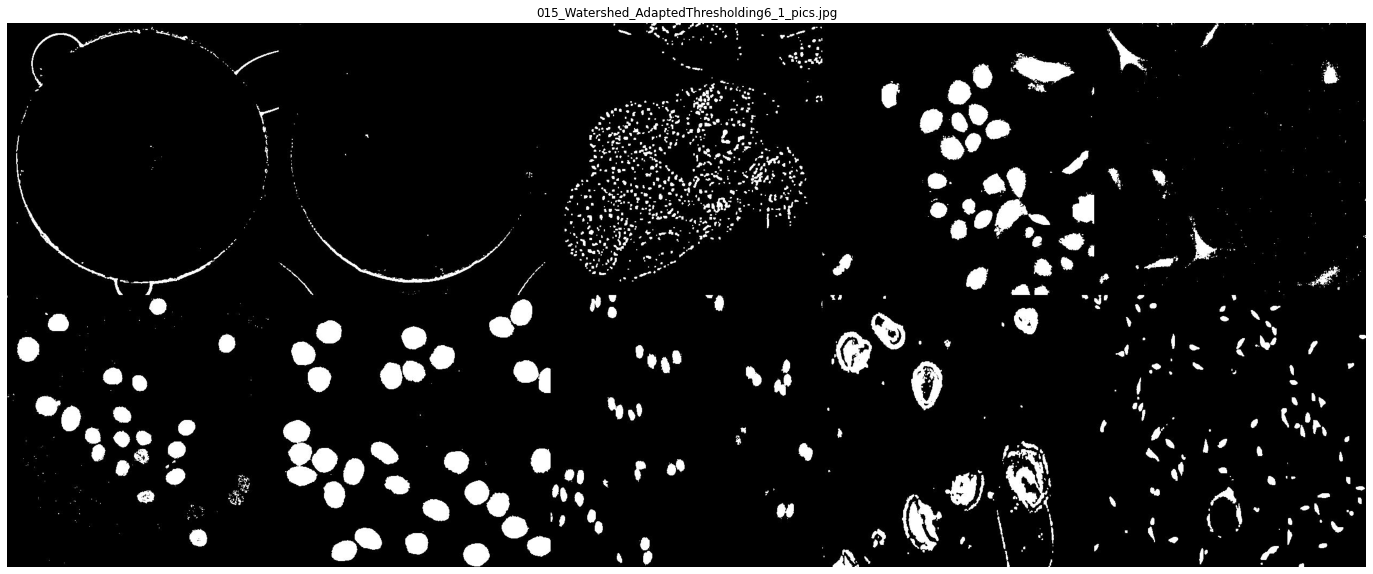

In [52]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted6(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "015_Watershed_AdaptedThresholding6_1_pics.jpg")

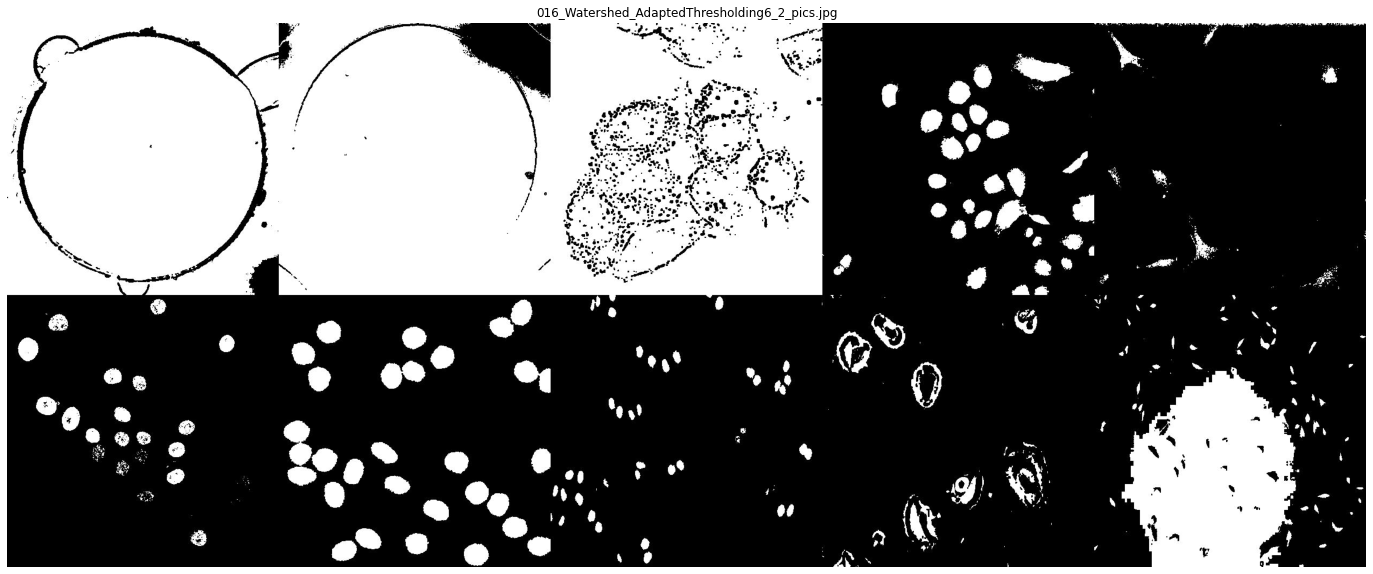

In [53]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholdingAdapted6(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "016_Watershed_AdaptedThresholding6_2_pics.jpg")

That top one may be our best option yet! Though the 3rd data-set is barely noticeable

Let us finish these combinations for now:

In [88]:
def watershedThresholdingAdapted7(img):
    # threshold
    ret, thresh = cv2.threshold(img, 0, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C + cv2.THRESH_TRIANGLE)

    return thresh

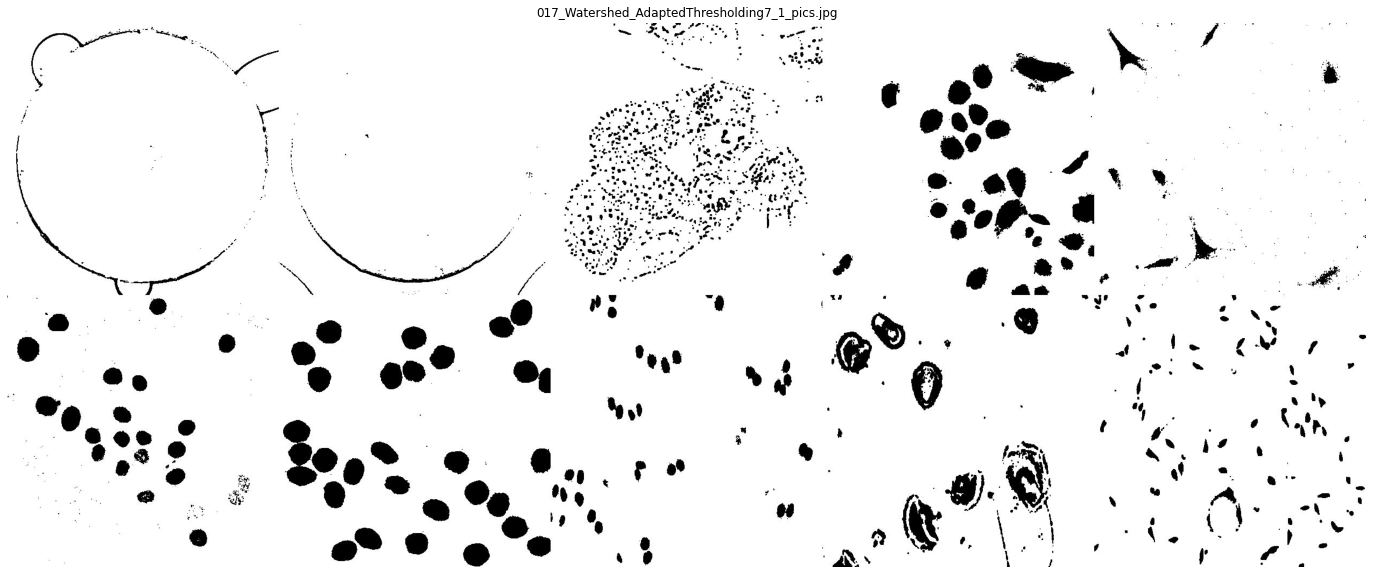

In [89]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted7(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "017_Watershed_AdaptedThresholding7_1_pics.jpg")

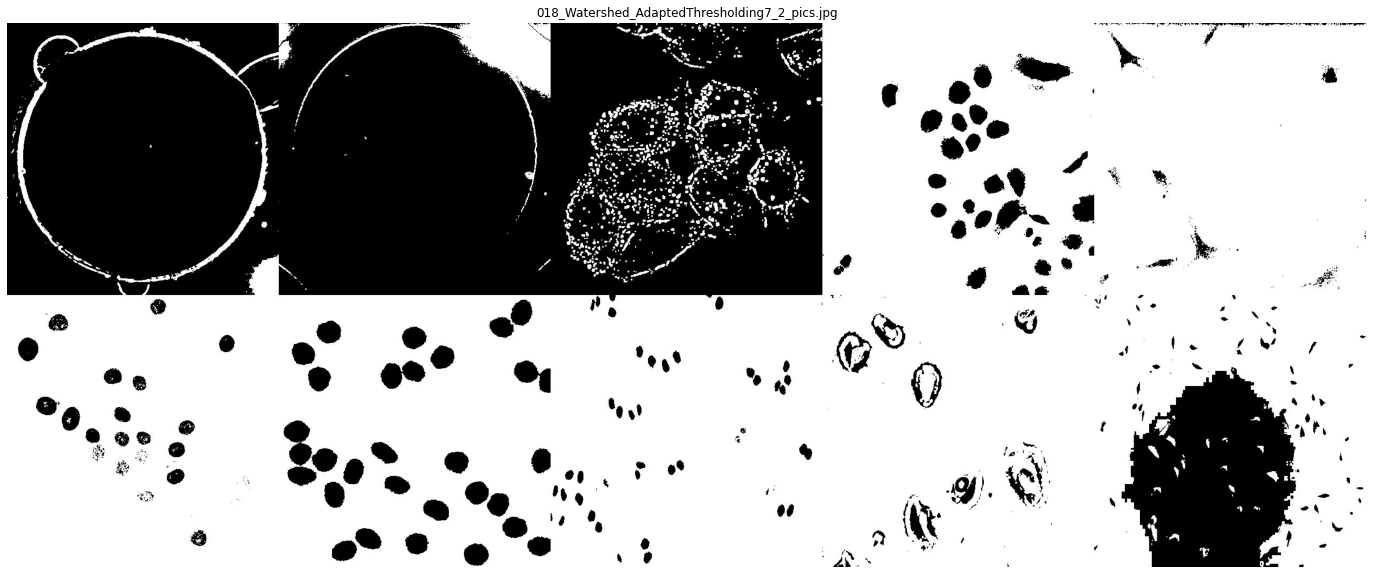

In [90]:
image_collection = []

for i in range(len(location2_pics)):
    image = location2_pics[i]

    watershed_image = watershedThresholdingAdapted7(image)

    image_collection.append(watershed_image)

saveAndShow(destination_directory, image_collection, "018_Watershed_AdaptedThresholding7_2_pics.jpg")

That top one, inverted may be pleasant:

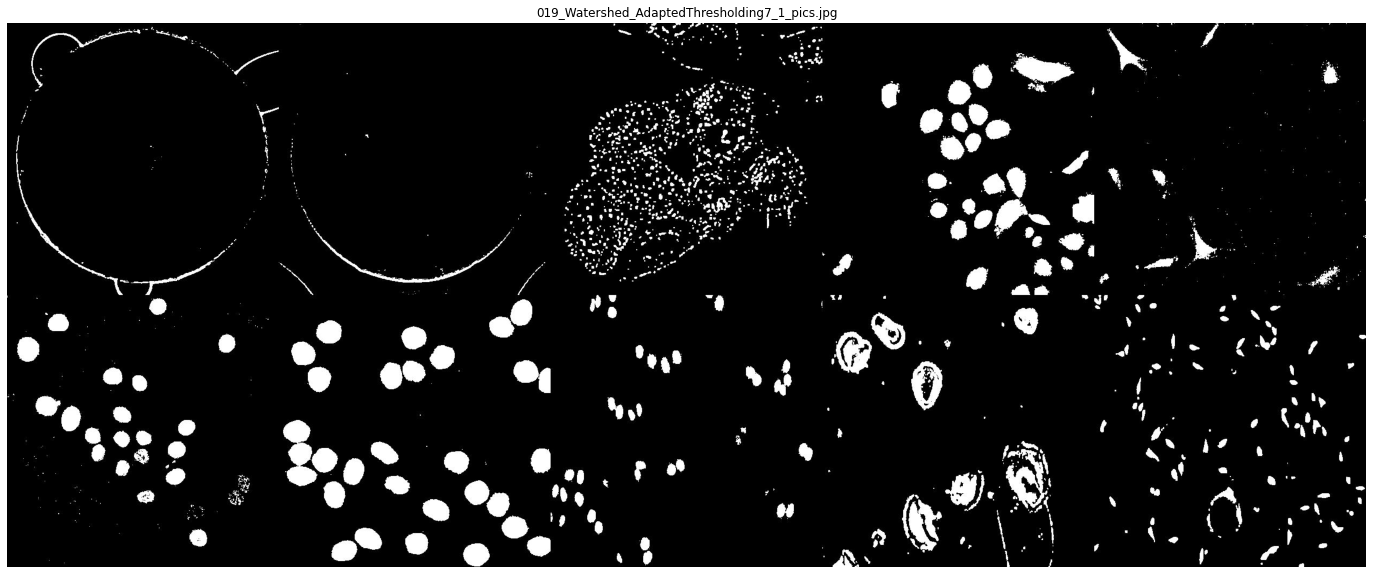

In [93]:
image_collection = []

for i in range(len(location1_pics)):
    image = location1_pics[i]

    watershed_image = watershedThresholdingAdapted7(image)
    negative_image = 255 - watershed_image

    image_collection.append(negative_image)

saveAndShow(destination_directory, image_collection, "019_Watershed_AdaptedThresholding7_1_pics.jpg")

We can consider replacing the successful ones of these images into our watershed algorithm and see if that helps things!